# Machine Learning with Molecular Fingerprints
The first type of representation we will demonstrate are "fingerprints" which describe a molecule with a list of binary features that, roughly, indicate whether a molecule has a certain substructure. 

Along the way, we are going to show you how to write your own "Transformer" classes that integrate computing features in your machine learning models and illustrate the importance of feature selection.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit import Chem
from tqdm import tqdm
import pandas as pd
import numpy as np

## Load Sample Data
We are going to use the QM9 subset from previous problems.

In [2]:
data = pd.read_json('datasets/qm9.json.gz', lines=True)#.sample(5000)
len(data)

25000

## Efficiently Computing Fingerprints
We are going to make a utility class that simplifies computing fingerprints using scikit-learn's [BaseEstimator](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html) class. Building a class with BaseEstimator allows it to work with some of the other functionality from scikit-learn, such as the Pipeline.

*Aside*: Read [this](https://www.w3schools.com/python/python_classes.asp) if you are unfamiliar with Python classes.

Step 1: A simple function for computing fingerprints

In [3]:
def compute_morgan_fingerprints(smiles: str, fingerprint_length: int, fingerprint_radius: int):
    """Get Morgan Fingerprint of a specific SMILES string.
    Adapted from: <https://github.com/google-research/google-research/blob/
    dfac4178ccf521e8d6eae45f7b0a33a6a5b691ee/mol_dqn/chemgraph/dqn/deep_q_networks.py#L750>
    Args:
      graph (str): The molecule as a SMILES string
      fingerprint_length (int): Bit-length of fingerprint
      fingerprint_radius (int): Radius used to compute fingerprint
    Returns:
      np.array. shape = [hparams, fingerprint_length]. The Morgan fingerprint.
    """
    # Parse the molecule
    molecule = Chem.MolFromSmiles(smiles)

    # Compute the fingerprint
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(
        molecule, fingerprint_radius, fingerprint_length)
    arr = np.zeros((1,), dtype=np.bool_)

    # ConvertToNumpyArray takes ~ 0.19 ms, while
    # np.asarray takes ~ 4.69 ms
    DataStructs.ConvertToNumpyArray(fingerprint, arr)
    return arr

In [4]:
compute_morgan_fingerprints('C', 4, 4)  # As an example, compute methane

array([ True, False, False, False])

In [5]:
class MorganFingerprintTransformer(BaseEstimator, TransformerMixin):
    """Class that converts SMILES strings to fingerprint vectors"""
    
    def __init__(self, length: int = 256, radius: int = 4):
        self.length = length
        self.radius = radius
    
    def fit(self, X, y=None):
        return self  # Do need to do anything
    
    def transform(self, X, y=None):
        """Compute the fingerprints
        
        Args:
            X: List of SMILES strings
        Returns:
            Array of fingerprints
        """
        
        fing = [compute_morgan_fingerprints(m, self.length, self.radius) for m in X]
        return np.vstack(fing)
m = MorganFingerprintTransformer(4, 4)
m.transform(['C'])

array([[ True, False, False, False]])

Ok, we are now ready to use Morgan fingerprints easily

## KNN Regressor
The k-Nearest-Neighbor (KNN) regressor is one of the conceptually simplest ML algorithms. You find the $k$ entries that are most similar to a record and predict by taking the average values of their classes. One additional thing to know about it is that scikit-learn's [KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) lets you configure the similarity metric.

There are actually a [multitude of ways](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html#sklearn.neighbors.DistanceMetric) to measure distance between two vectors. Some are better suited for continuous values and others are good for lists of True/False values, such as fingerprints. Of these, the QSAR community [typically uses](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-015-0069-3) the [Jaccard/Tanimoto Distance](https://en.wikipedia.org/wiki/Jaccard_index).

Before testing, let's make a training and test set

In [6]:
train_data, test_data = train_test_split(data, test_size=0.25)

And precompute the featurs

In [7]:
m.length = 256
test_fng = m.transform(test_data['smiles_0'])
train_fng = m.transform(train_data['smiles_0'])

Let's fit a model to the training set

In [8]:
krr = KNeighborsRegressor(n_neighbors=3, metric='jaccard')

In [9]:
%%time
krr.fit(train_fng, train_data['bandgap'])

CPU times: user 351 µs, sys: 254 µs, total: 605 µs
Wall time: 544 µs


KNeighborsRegressor(metric='jaccard', n_neighbors=3)

Notice how fast the model trains! It isn't learning any parameters, just storing the training data in a way that it's easy to look up neighbors later

In [10]:
%%time
y_pred = krr.predict(test_fng)

CPU times: user 11.1 s, sys: 180 ms, total: 11.3 s
Wall time: 11.3 s


Running the model, on the other hand, takes longer. Looking up the nearest neighbors for each point is expensive

Text(0, 0.5, '$E_g$, True')

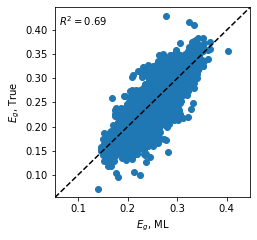

In [11]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

r2 = r2_score(y_pred, test_data['bandgap'])
ax.text(0.02, 0.9, f'$R^2 = {r2:.2f}$', transform=ax.transAxes)
ax.scatter(y_pred, test_data['bandgap'])

ax.set_xlabel('$E_g$, ML')  
ax.set_ylim(ax.get_ylim())
ax.set_xlim(ax.get_ylim())
ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')
    
ax.set_ylabel('$E_g$, True')

Overall, the model doesn't do too bad.

## Faster KNN with GPU: cuML
The Rapids project has made the ability to run many data science techniques, including ML algorithms, on the GPU. No mean feat!

*WARNING*: These cells require you to run a GPU-enabled system. If you don't have one, skip ahead to "Pipeline."

In [ ]:
# RAPIDS cuML kNN model
import cudf, cuml
from cuml.neighbors import KNeighborsRegressor as cuKNeighbors

The Rapids version of the model behaves just like the sklearn version, though it has some different distance metrics available. `braycurtis` is the closest to the Jaccard distance we used.

In [ ]:
import cuml

In [ ]:
sorted(cuml.neighbors.VALID_METRICS['brute'])

In [ ]:
model = cuKNeighbors(n_neighbors=3, metric='braycurtis')

In [ ]:
%%time
model.fit(train_fng, train_data['bandgap'])

In [ ]:
%%time
y_hat = model.predict(test_fng)

The first time you run the cell above it will be slower because of initialization overhead. If you run it again it will be _much_ faster than the CPU version.

In [ ]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

r2 = r2_score(y_hat, test_data['bandgap'])
ax.text(0.02, 0.9, f'$R^2 = {r2:.2f}$', transform=ax.transAxes)
ax.scatter(y_hat, test_data['bandgap'])

ax.set_xlabel('$E_g$, ML')  
ax.set_ylim(ax.get_ylim())
ax.set_xlim(ax.get_ylim())
ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')
    
ax.set_ylabel('$E_g$, True')

It does just as well!

## Making a Pipeline
Always a good plan for doing experiments as it lets you configure things easier

In [12]:
model = Pipeline([
    ('fingerprint', MorganFingerprintTransformer()),
    ('knn', KNeighborsRegressor(n_neighbors=2, metric='jaccard', n_jobs=-1))  # n_jobs = -1 lets the model run all available processors
])

## Evaluate the Effect of Training Set Size
See how the model performs as we increase data with using two different fingerprint lengths

In [13]:
# A common pattern of work in ML is to try a few variations of parameters
#  and assess their performance. I prefer to use a pattern where I loop
#  over all of those parameters and then store them as a Pandas DataFrame.
#  You'll see how to do that in this cell
results = []
for l in [32, 64, 128]:
    model.set_params(fingerprint__length=l)
    for s in tqdm([3, 10, 30, 100, 300, 1000, 3000], desc=f'l={l}'):  # Loop over different training set sizes
        for i in range(16):  # Repeat the experiment
            subset = train_data.sample(s)  # Downselect to the desired size

            # Train and test the model
            model.fit(subset['smiles_0'], subset['bandgap'])
            y_pred = model.predict(test_data['smiles_0'])

            # Store the results
            #  Use a list of dictionaries, which I can convert to 
            #  a DataFrame very easily
            results.append({
                'length': l,
                'train_size': s,
                'iteration': i,
                'r2_score': r2_score(test_data['bandgap'], y_pred),
                'mae': mean_absolute_error(test_data['bandgap'], y_pred)
            })
results = pd.DataFrame(results)  # Converts to a dataframe

l=128: 100%|██████████| 7/7 [01:01<00:00,  8.82s/it]


Plot the results

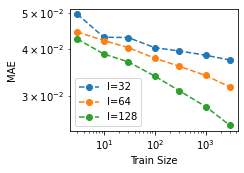

In [14]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

# Group loops over subsets with the same value for
#  a certain column. "gid" is that value, and group
#  is a DataFrame with that population of data
for gid, group in results.groupby('length'):
    # First, group by the training set size and compute the average over averages
    #  The data is already grouped by length, so here we just need to compute the 
    #  average for all groups with the same training set size
    #
    #  You can do that in one line with Pandas:
    #  https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html
    group_stats = group.groupby('train_size').mean()
    
    ax.loglog(group_stats.index, group_stats['mae'], '--o', label=f'l={gid}')
    
ax.legend()

ax.set_xlabel('Train Size')
ax.set_ylabel('MAE')
fig.tight_layout()

Note how the difference between the performance of models depending on the fingerprint length increases with training set size. 
They are all effectively equivalent at dataset sizes of 3 training sets, but are very different at 3000 entries. 

The benefit for the increased fingerprint length is that it can disambuigate better between molecules and this becomes important
when you have a greater number of molecules to distinguish between. 
This notion of "larger datasets can benefit from more complex models" is one of the big lessons of machine learning.